In [289]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

import csv
from datetime import datetime
from datetime import timedelta
#from struct import pack
import os
import gc
from numpy import abs, max 
import scipy
#from scipy import io
import numpy as np
from matplotlib import pyplot as plt
#from scipy.signal import butter, lfilter
from scipy import signal
#from scipy.signal import blackman
#from scipy.signal import periodogram
#import gc
#import os
import sys
import pandas as pd
#from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.spatial import distance

gc.enable()

video_start = '20190501'#'20190327'#'20181220' #YYYYMMDD
video_end = '20190501'#'20190327'#'20181220' #YYYYMMDD
data_path = '/data/'
sensor_list = ["acc_w","wifi"]#["gyro","acc2","acc_w","wifi","magnetic"]

temp_video_start = video_start[0:4] + "/" + video_start[4:6] + "/" +video_start[6:8]
temp_video_end = video_end[0:4] + "/" + video_end[4:6] + "/" +video_end[6:8]
print temp_video_start
print temp_video_end

video_startdatte = datetime.strptime(temp_video_start,'%Y/%m/%d')
video_enddate = datetime.strptime(temp_video_end,'%Y/%m/%d')

2019/05/01
2019/05/01


In [255]:
root = "env/"

envs = os.listdir(root)
envs = envs[0:len(envs)-1]
envs = [int(x) for x in envs]
envs.sort()

In [256]:
print "Please select a trainining environment from the following environments list:"

for i in envs:
    print "Environment: (",i,")"
    
train_env = raw_input("Training environment ")

train_env = int(train_env)

Please select a trainining environment from the following environments list:
Environment: ( 5 )
Environment: ( 6 )
Environment: ( 8 )
Environment: ( 9 )
Environment: ( 10 )
Training environment 8


In [257]:
train_root = root + str(train_env) + "/dat/" + "train_dat/"

In [258]:
acc = pd.read_csv("env/" + str(train_env) + "/dat/" + "acc")
labels = pd.read_csv("env/" + str(train_env) + "/dat/" + "labels")
acc.drop(["Unnamed: 0"], axis=1, inplace=True)
labels.drop(["Unnamed: 0"], axis=1, inplace=True)

In [259]:
if len(acc)!=len(labels):
    print "ERROR: Length mismatch!"

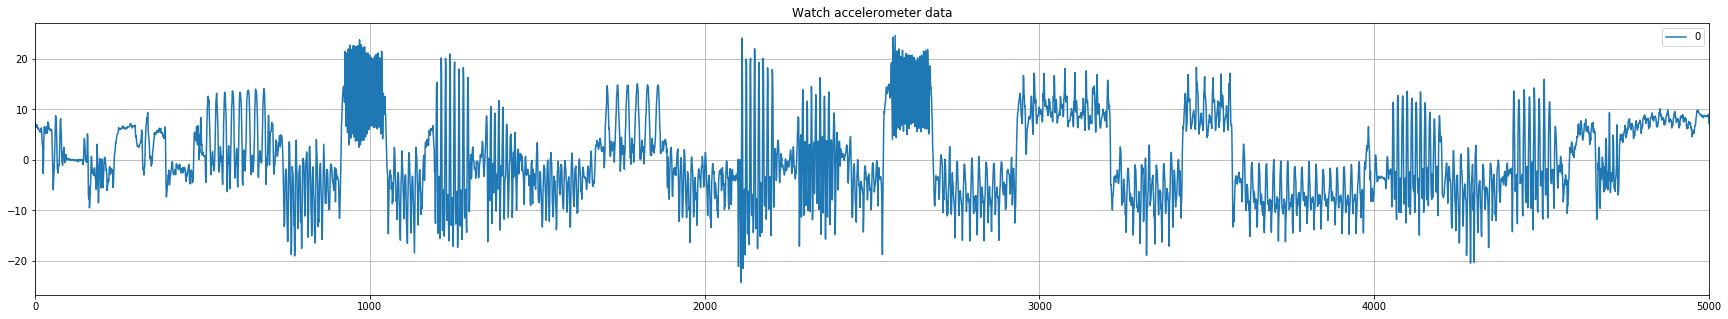

In [260]:
acc.plot(figsize = (30,5),title="Watch accelerometer data",grid=1,xlim=[0,len(acc)])

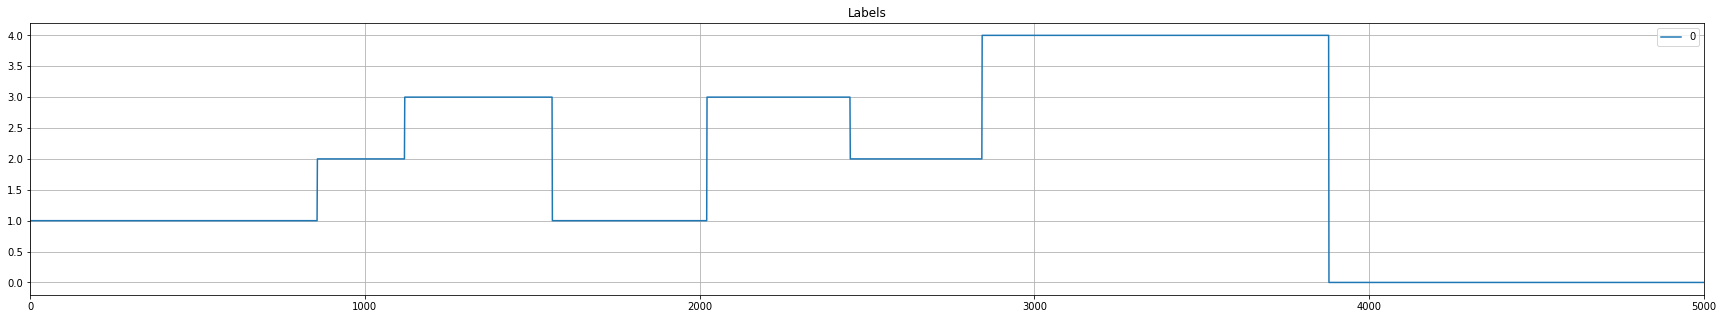

In [261]:
labels.plot(figsize = (30,5),title="Labels",grid=1,xlim=[0,len(labels)])

In [262]:
place_cluster = labels

In [263]:
place_cluster = place_cluster.values.reshape(-1).tolist()
places = set(place_cluster)

place = []
for p in places:
    loc = []
    for c in place_cluster:
        if p == c:
            loc.append(1)
        else:
            loc.append(0)
    place.append(loc)
            

In [264]:
places

{0, 1, 2, 3, 4}

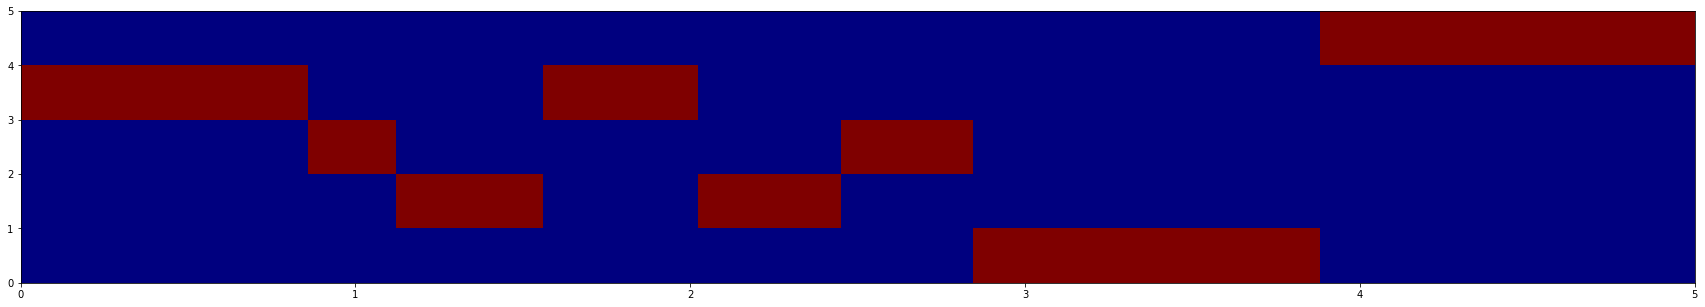

In [265]:
plt.figure(figsize=(30,5))
plt.imshow(place,cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(places),0,len(place)], aspect='auto')

# Acceleration distance matrix calculation

In [266]:
window_len = 100
from sklearn import preprocessing
#Euclidian distance (edges have to be filled with zeros)
window_len = window_len
dist_mat = []
#std = []
y_window = []

acc_max = acc.max()
acc_min = acc.min()

for z in tqdm(range(0,len(acc)-window_len)):
    #std.append(acc[z:window_len+z].std())
    #avg.append(acc[z:window_len+z].mean())
    y_window.append((acc[z:window_len+z] - acc[z:window_len+z].mean() )/acc[z:window_len+z].std())


for y in tqdm(range(0,len(acc)-window_len)):
    feature = []
    #feature.extend(np.zeros(window_len/2))
    feature.extend(np.full((1, (window_len/2)), acc_max-acc_min).tolist()[0])
    #y_window = (acc[y:window_len+y] - avg[y])/std[y]
    for x in range(0,len(acc)-window_len):
        feature.append(distance.euclidean(y_window[y],y_window[x]))

    feature.extend(np.full((1, (window_len/2)), acc_max-acc_min).tolist()[0])
        
    dist_mat.append(feature)

100%|██████████| 4901/4901 [21:23<00:00,  3.87it/s]


In [267]:
acc_dist_mat = []
for n in range(0,window_len/2):
    #acc_dist_mat.append(np.zeros(len(np.array(dist_mat).T)).tolist())
    acc_dist_mat.append(np.full((1, len(np.array(dist_mat).T)), acc_max-acc_min).tolist()[0])
    
for line in dist_mat:
    acc_dist_mat.append(line)

for n in range(0,window_len/2):
    #acc_dist_mat.append(np.zeros(len(np.array(dist_mat).T)).tolist())
    acc_dist_mat.append(np.full((1, len(np.array(dist_mat).T)), acc_max-acc_min).tolist()[0])

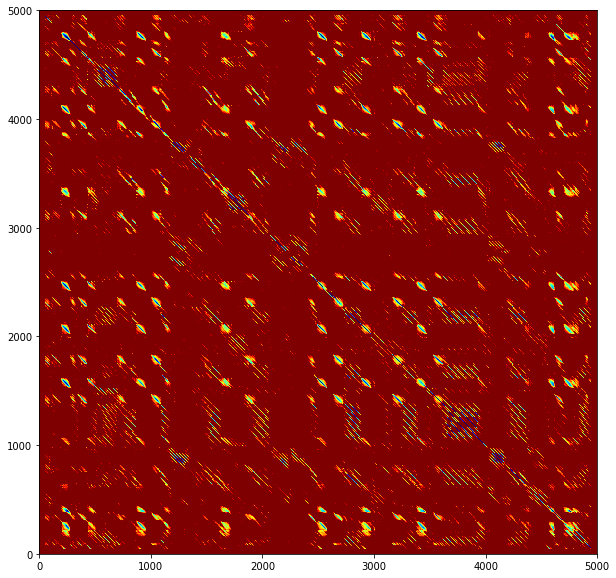

In [268]:
plt.figure(figsize=(10,10))
plt.imshow(acc_dist_mat, cmap='jet', vmax=12, vmin=5, interpolation='nearest', origin='upper', extent=[0,len(acc_dist_mat),0,len(acc_dist_mat)], aspect='auto')
#plt.colorbar()

In [269]:
train_root

'env/8/dat/train_dat/'

In [270]:
pd.DataFrame(acc_dist_mat).to_csv(train_root + "acc_dist_mat", header=False, index=False)

## Acceleration similarity matrix calculation

In [271]:
max_dist = np.array(acc_dist_mat).max()
similarity_matrix = []
for feature in acc_dist_mat:
    sim = []
    for element in feature:
        simv=1.0-element/max_dist
        sim.append(simv if simv>0.8 else 0.0)
    similarity_matrix.append(sim)

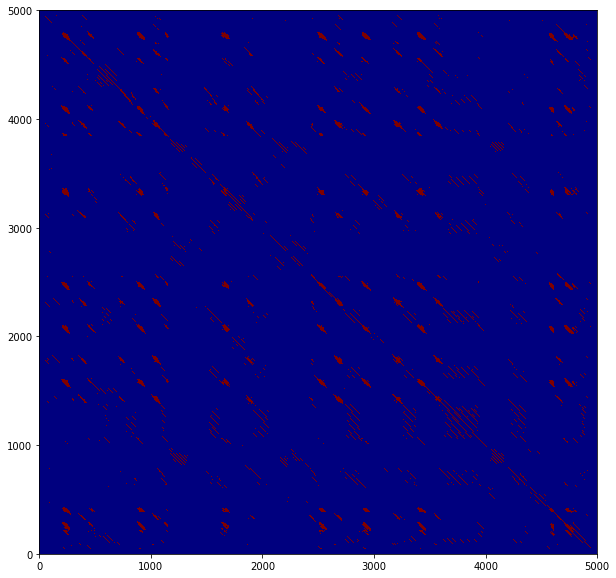

In [272]:
plt.figure(figsize=(10,10))
plt.imshow(similarity_matrix, cmap='jet', vmax=0.8, interpolation='nearest', origin='upper', extent=[0,len(similarity_matrix),0,len(similarity_matrix)], aspect='auto')
#plt.colorbar()

# Calculating Similarity Coefficient

In [273]:
prob = []
num = 0
for items in np.array(similarity_matrix):
    p = []
    denom_array = []
    for m in range(0,len(places)):
        denom_array.append(np.multiply(place[m],items)/np.sum(place[m]))
        denom = np.sum(denom_array)
    for n in range(0,len(places)):
        if np.sum(np.multiply(items,np.asarray(place))) == 0.0:
            p.append(1.0/len(places))
            #print np.sum([np.multiply(items,place[0]) , np.multiply(items,place[1]) , np.multiply(items,place[2])])
        else:
            p.append((np.sum(np.multiply(place[n],items))/np.sum(place[n])) / denom)#np.sum([np.multiply(items,place[0])/np.sum(place[0]) , np.multiply(items,place[1])/np.sum(place[1]) , np.multiply(items,place[2])/np.sum(place[2])]))#/np.sum([np.multiply(items,place[0]) , np.multiply(items,place[1]) , np.multiply(items,place[2])])
    prob.append(p)

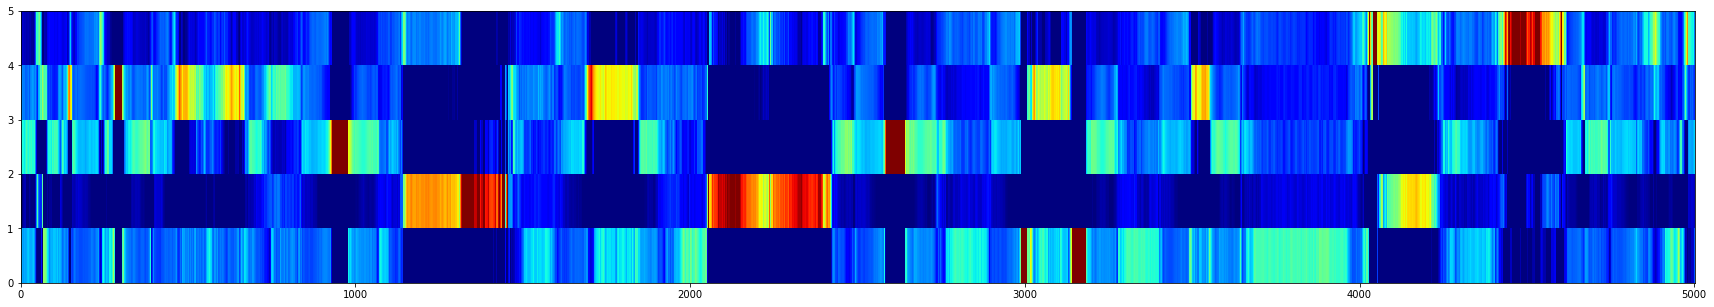

In [274]:
plt.figure(figsize=(30,5))
plt.imshow(np.array(prob)[50:len(similarity_matrix)-50].T,cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(prob),0,len(place)], aspect='auto')
#plt.colorbar()

In [275]:
pd.DataFrame(prob).T.to_csv(train_root + "env_mot_probs", header=False, index=False)

In [276]:
prob_sum = []
for probs in prob:
    prob_sum.append(np.sum(np.power(probs,2)))

gini = []
for items in prob_sum:
    gini.append(1-items)

In [277]:
pd.DataFrame(prob_sum).to_csv(train_root + "sim_coefs", header=False, index=False)

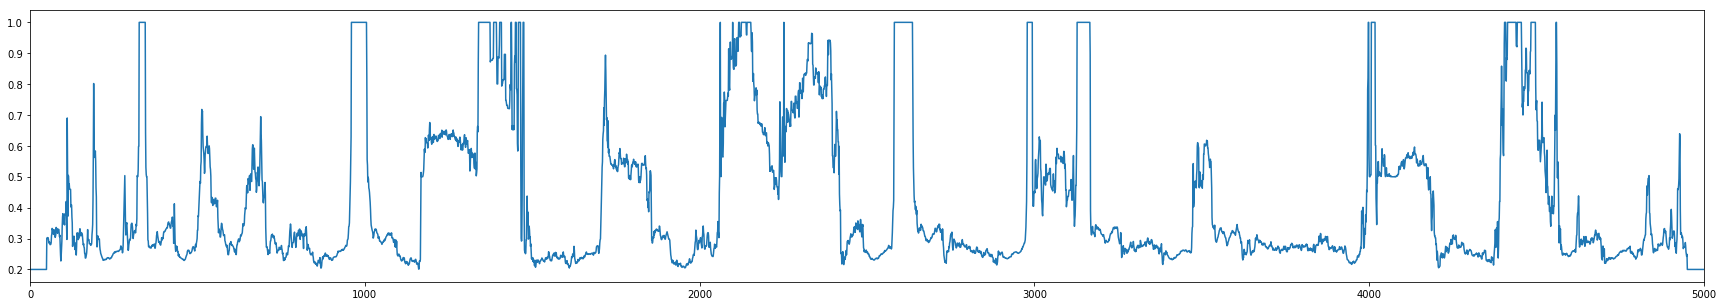

In [278]:
plt.figure(figsize=(30,5))
plt.xlim(0,len(prob_sum))
plt.plot(prob_sum)

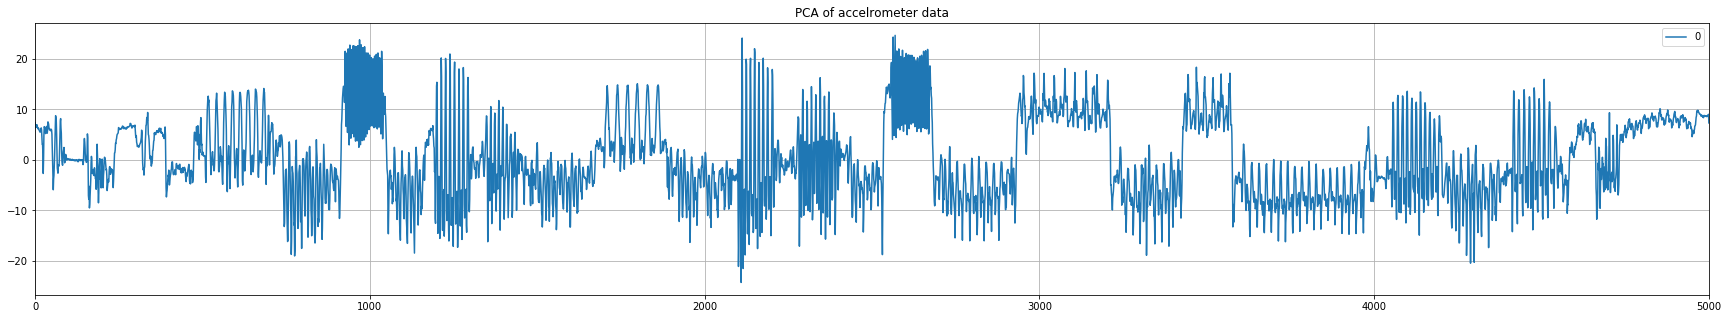

In [279]:
acc.plot(figsize = (30,5),title="PCA of accelrometer data",grid=1,xlim=[0,len(acc)])

In [280]:
all_motif_locations = []
for sample in range(0,len(prob_sum)):
    itr = []
    if prob_sum[sample]>=0.8:
        all_motif_locations.append(sample)    

In [281]:
pd.DataFrame(all_motif_locations)

,0
0,190
1,326
2,327
3,328
4,329
5,330
6,331
7,332
8,333
9,334


In [282]:
all_mots = []
locs = []
mot_labels = []

for m_loc in all_motif_locations:
    if m_loc>=window_len/2 and m_loc<len(acc)-window_len/2:
        locs.append(m_loc)
        mot_labels.append(labels.values[m_loc])
        all_mots.append(acc.values[m_loc-window_len/2:m_loc+window_len/2])

In [283]:
all_mots = np.array(all_mots).reshape(len(all_mots),window_len)

In [284]:
all_mots = pd.DataFrame(all_mots)
mot_labels = pd.DataFrame(mot_labels,columns=["label"])

In [285]:
all_mots = pd.concat([mot_labels,all_mots],axis = 1,sort=False)

In [286]:
pd.DataFrame(all_mots).to_csv(train_root + "all_mots", header=False, index=False)

# *** Will be used after a while ***

# Clustering similarity coefficients

In [99]:
mot_loc = []
for x in range(0,len(prob_sum)):
    if(prob_sum[x]>0.8):
        #mot_loc.append([x,prob_sum[x]])
        mot_loc.append(x)

In [100]:
mot_sim_mat = []
for locs in mot_loc:
    #mot_dist_mat.append(np.array(similarity_matrix[locs])[mot_loc])
    mot_sim_mat.append(np.array(similarity_matrix[locs])[mot_loc])


In [101]:
mot_dist_mat = []
for feature in mot_sim_mat:
    sim = []
    for element in feature:
        sim.append(1.0-element)
    mot_dist_mat.append(sim)

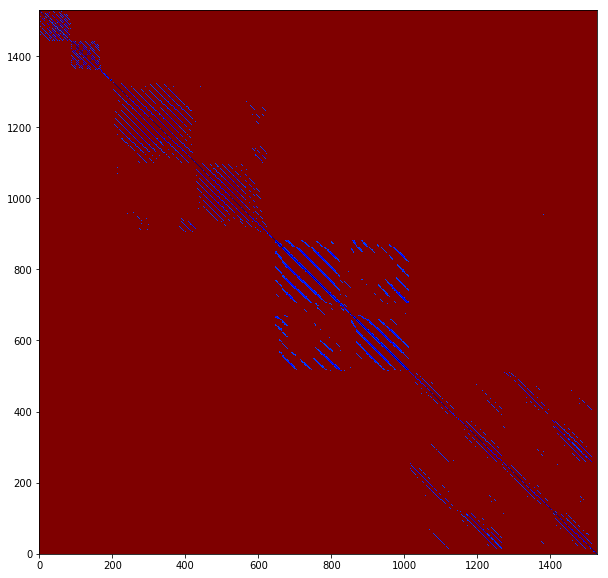

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(mot_dist_mat,cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(mot_sim_mat),0,len(mot_sim_mat)], aspect='auto')

In [288]:
pd.DataFrame(mot_dist_mat)

,0,1,2,3,4,5,6,7,8,9,...,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528
0,0.000000,0.111682,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.111682,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.0,0.000000,0.162200,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.0,0.162200,0.000000,0.168430,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.0,1.000000,0.168430,0.000000,0.172541,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.0,1.000000,1.000000,0.172541,0.000000,0.176854,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.176854,0.000000,0.184083,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.184083,0.000000,0.187018,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.187018,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

mot_dist_array = ssd.squareform(mot_dist_mat)

Z = linkage(mot_dist_array, method='single', metric='euclidean')

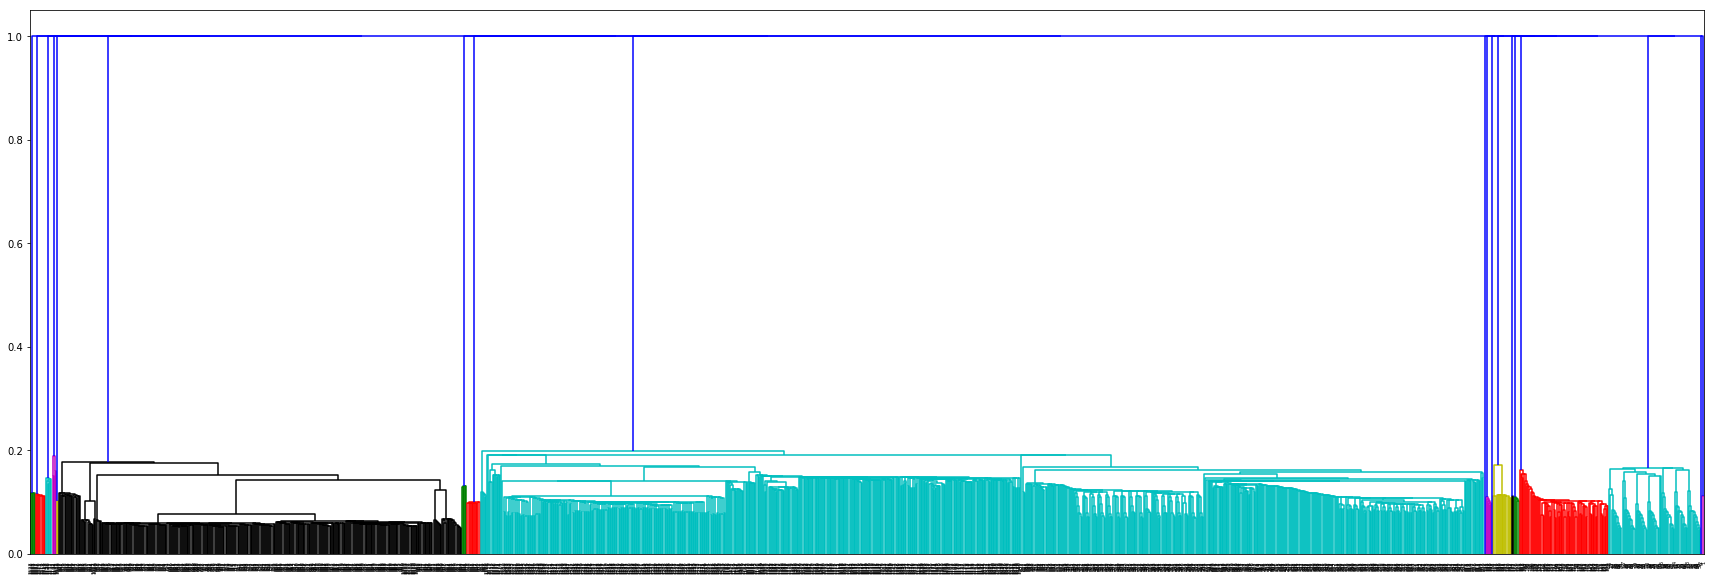

In [104]:
plt.figure(figsize=(30,10))
dn = dendrogram(Z)
plt.show()

In [105]:
t = 0.6*max(Z[:,2])
clusters = fcluster(Z, t, criterion="distance")

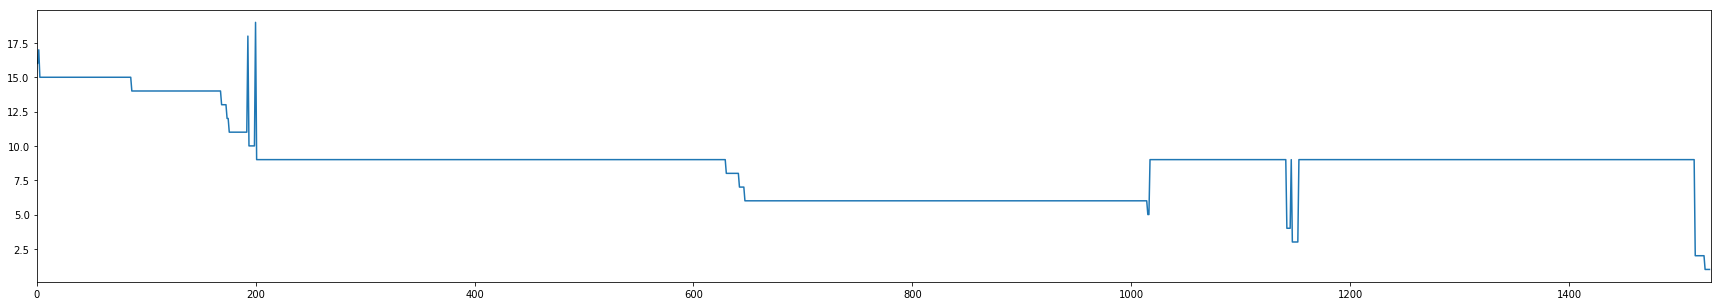

In [106]:
plt.figure(figsize=(30,5))
plt.xlim(0,len(clusters))
plt.plot(clusters)

In [107]:
cluster_loc = []
for y in range(0,len(mot_loc)):
    cluster_loc.append([mot_loc[y],clusters[y]])

In [108]:
times_cluster = []
for z in range(0,len(acc)):
    times_cluster.extend([0])

In [109]:
for itm in cluster_loc:
    times_cluster[itm[0]] = itm[1]

In [114]:
pd.DataFrame(times_cluster).to_csv(train_root + "mot_clusters", header=False, index=False)

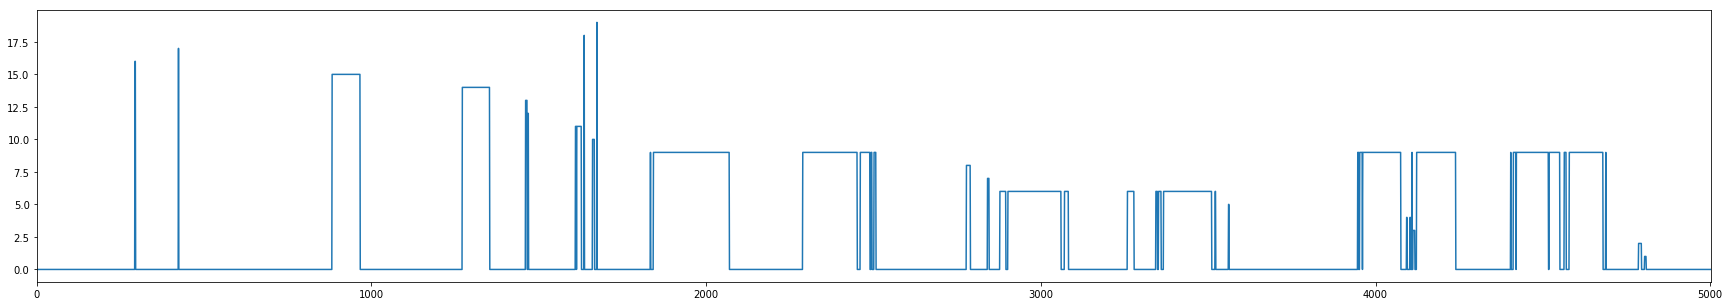

In [115]:
plt.figure(figsize=(30,5))
plt.xlim(0,len(times_cluster))
plt.plot(times_cluster)

In [116]:
place_times_cluster = np.vstack((place_cluster, times_cluster)).T

In [117]:
env_mot_list = []

for env in set(place_cluster):
    #print env
    pmcombo = place_times_cluster[place_times_cluster[:,0]==env]
    mot_list = []
    for motif in set(times_cluster):#set(pmcombo[:,1]):
        envmot = pmcombo[:,1]
        #print int(motif), envmot.tolist().count(motif)
        mot_list.append([int(motif), envmot.tolist().count(motif)])
        
    env_mot_list.append([int(env),mot_list])    
    #for motif in set(times_cluster):
     #   print no, times_cluster.count(no)

In [118]:
motif_occur = []
for no in set(times_cluster):
    if no != 0:
        motif_occur.append([no, times_cluster.count(no)])

In [119]:
motif_occur

[[1, 5],
 [2, 9],
 [3, 6],
 [4, 4],
 [5, 2],
 [6, 368],
 [7, 5],
 [8, 12],
 [9, 917],
 [10, 6],
 [11, 17],
 [12, 2],
 [13, 5],
 [14, 82],
 [15, 84],
 [16, 2],
 [17, 1],
 [18, 1],
 [19, 1]]

In [120]:
motif_occur = np.asarray(motif_occur)

In [121]:
mot_sum = float(sum(motif_occur[:,1]))

In [122]:
mot_ratio = []
for mots in motif_occur:
    mot_ratio.append([mots[0],float(mots[1])/mot_sum])

In [123]:
mot_ratio

[[1, 0.0032701111837802484],
 [2, 0.005886200130804447],
 [3, 0.003924133420536298],
 [4, 0.002616088947024199],
 [5, 0.0013080444735120995],
 [6, 0.2406801831262263],
 [7, 0.0032701111837802484],
 [8, 0.007848266841072597],
 [9, 0.5997383911052976],
 [10, 0.003924133420536298],
 [11, 0.011118378024852845],
 [12, 0.0013080444735120995],
 [13, 0.0032701111837802484],
 [14, 0.053629823413996074],
 [15, 0.05493786788750817],
 [16, 0.0013080444735120995],
 [17, 0.0006540222367560497],
 [18, 0.0006540222367560497],
 [19, 0.0006540222367560497]]

In [124]:
feature_list = []
for x in range(0,len(env_mot_list)):
    for y in range(0,len(env_mot_list[x][1])):
        feature_list.append([x,y,float(env_mot_list[x][1][y][1])/mot_sum])

In [126]:
pd.DataFrame(feature_list)

,0,1,2
0,0,0,0.440157
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.000000
4,0,4,0.000000
5,0,5,0.000000
6,0,6,0.000000
7,0,7,0.000000
8,0,8,0.000000
9,0,9,0.280576
